# Modèles RNN 

NOTEBOOK PRENDS 1H A S'EXECUTER

# Import des librairies

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline

from gensim.models.word2vec import Word2Vec
import gensim

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras_preprocessing.sequence import pad_sequences

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import itertools
import time
from datetime import datetime 

2022-07-18 17:12:17.668488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 17:12:17.668529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
a = datetime.now()

# Import des données

In [3]:
# Import pre-processed data
df = pd.read_csv('data/df_preprocessing_final.csv')

# Suppression des colonnes inutiles
df = df.drop(columns=['user', 'id', 'nombre_mot'])

df.head()

,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url that is bummer you should got david c...,user url that is bummer you should got david c...,user url that be bummer you should got david c...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,is upset that he cannot updat hi facebook by t...,be upset that he can not update his facebook b...
2,0,@Kenichan I dived many times for the ball. Man...,user dived many times for the ball managed to ...,user dive mani time for the ball manag to save...,user dive many time for the ball manage to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,my whole bodi feel itchi and like it is on fire,my whole body feel itchy and like it be on fire
4,0,"@nationwideclass no, it's not behaving at all....",user no it is not behaving at all am mad why a...,user no it is not behav at all am mad whi am h...,user no it be not behave at all be mad why be ...


In [4]:
# Nous allons récuperer un sample de notre dataframe
row = 7000  # Resultat intéressant avec 5000 lignes | mieux avec 7000

# Permet de garder un équilibrage de la target contrairement à un
# .sample() basique
df_sample = df.groupby('sentiment').apply(
    lambda x: x.sample(n=row, random_state=42))
df_sample.reset_index(drop=True, inplace=True)

In [5]:
print(df_sample.shape)
print(df_sample.sentiment.value_counts())
df_sample.head()

(14000, 5)
0    7000
1    7000
Name: sentiment, dtype: int64


,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm
0,0,"@LeahMul awh, thats not good, get better soon!",user awh that is not good get better soon,user awh that is not good get better soon,user awh that be not good get well soon
1,0,I need a job,need job,need job,need job
2,0,i am pretty sure i have swine flu woohooo one...,am pretty sure have swine flu woohooo one tes...,am pretti sure have swine flu woohooo one tes...,be pretty sure have swine flu woohooo one tes...
3,0,GLG will never EVER be the same,glg will never ever be the same,glg will never ever be the same,glg will never ever be the same
4,0,Enjoying my last days w/ my 1 year old Where ...,enjoying my last days my year old where does t...,enjoy my last day my year old where doe the fr...,enjoy my last day my year old where do the frk...


# Word embedding

## Word2Vec

**Word2Vec** a été développé par Google, contrairement aux méthodes **One Hot Encoding et TF-IDF**, un processus d'apprentissage non supervisé est effectué. 

Les données non étiquetées sont entraînées par des **réseaux neuronaux artificiels** pour créer le modèle Word2Vec qui génère des vecteurs de mots. 

Contrairement aux autres méthodes, la taille du vecteur n'est pas aussi importante que le nombre de mots uniques dans le corpus. La taille du vecteur peut être sélectionnée en fonction de la taille du corpus et du type de projet. 
Cette méthode est particulièrement **avantageuse pour les données très volumineuses**. 

Par exemple, si nous supposons qu'il y a 300 000 mots uniques dans un grand corpus, lorsque la création du vecteur est effectuée avec **One Hot Encoding**, un vecteur de taille 300 000 est créé pour chaque mot, avec la valeur d'un seul élément de 1 et les autres 0. Cependant, en choisissant la taille de vecteur 300 (elle peut être plus ou moins grande selon le choix de l'utilisateur) du côté de **Word2Vec**, les opérations vectorielles inutiles de grande taille sont évitées.

source :https://www.districtdatalabs.com/modern-methods-for-sentiment-analysis

https://www.kaggle.com/code/caiyutiansg/twitter-sentiment-analysis-with-word2vec-lstm/notebook

In [6]:
df_word2vec = df_sample.copy()

Nous avons dans la cellule suivante fait appel à un modèle pré-entrainé sur environ 100 milliards de mots à partir de l'ensemble de données Google News pour notre wordembedding avec Word2Vec.

In [7]:
%%time
model = gensim.models.KeyedVectors.load_word2vec_format(
    'word2vec/GoogleNews-vectors-negative300.bin',
    binary=True)  #C binary format

CPU times: user 19.2 s, sys: 1.62 s, total: 20.8 s
Wall time: 37.5 s


Testons notre word embedding pour voir les relations entre les mots avec par exemple "woman" et "king".

In [8]:
%%time
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

CPU times: user 1.77 s, sys: 2.37 s, total: 4.14 s
Wall time: 4.08 s


[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581)]

Très intéressant, le premier résultat est "queen" qui sera la première chose que l'ont pourrait penser avec les mots 'woman' et king'.

Faisons maintenant une fonction pour encoder nos données avec Word2Vec.

Elle sera utilisé pour chaque type de tweet.

In [9]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 2  # 7 de base
W2V_EPOCH = 15
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 15
BATCH_SIZE = 100


def word2vec(type_tweet):

    documents = [_text.split() for _text in df_train[type_tweet]]

    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                                window=W2V_WINDOW,
                                                min_count=W2V_MIN_COUNT,
                                                workers=4)

    w2v_model.build_vocab(documents)

    words = w2v_model.wv.index_to_key
    vocab_size = len(words)
    print("Vocab size", vocab_size)

    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_train[type_tweet])

    vocab_size = len(tokenizer.word_index) + 1
    print("Total words", vocab_size)

    x_train = pad_sequences(tokenizer.texts_to_sequences(df_train[type_tweet]),
                            maxlen=SEQUENCE_LENGTH)
    x_test = pad_sequences(tokenizer.texts_to_sequences(df_test[type_tweet]),
                           maxlen=SEQUENCE_LENGTH)

    labels = df_train.sentiment.unique().tolist()

    encoder = LabelEncoder()
    encoder.fit(df_train.sentiment.tolist())

    y_train = encoder.transform(df_train.sentiment.tolist())
    y_test = encoder.transform(df_test.sentiment.tolist())

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    print("y_test", y_test.shape)
    print("x_train", x_train.shape)
    print("y_train", y_train.shape)
    print("x_test", x_test.shape)

    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    print(embedding_matrix.shape)

    embedding_layer = Embedding(vocab_size,
                                W2V_SIZE,
                                weights=[embedding_matrix],
                                input_length=SEQUENCE_LENGTH,
                                trainable=False)

    return x_train, x_test, y_test, y_train, embedding_layer, tokenizer

Nosu avons maintenant notre fonction qui sera utilisé dans la partie **Modèle | Word2Vec**. 

Appliquons le même procédé pour la partie Glov, de cette manière, les parties **Modèle | Word2Vec** et **Modèle | Glov** seront plus simplement construction avec quasiement que des appel de fonctions.

## Glov

L'avantage de **GloVe** est que, contrairement à **Word2vec**, **GloVe** ne s'appuie pas uniquement sur des statistiques locales (informations sur le contexte local des mots), mais intègre **des statistiques globales (cooccurrence des mots)** pour obtenir des vecteurs de mots. 

Mais gardez à l'esprit qu'il y a une certaine synergie entre **GloVe et Word2vec**.

Source : https://www.analyticsvidhya.com/blog/2021/12/sentiment-analysis-on-tweets-with-lstm-for-beginners/

In [10]:
df_glov = df_sample.copy()

In [11]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('glove.6B/glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
def glov(type_tweet):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_train[type_tweet])
    word_index = tokenizer.word_index

    vocab_size = len(tokenizer.word_index) + 1

    # The tokens are converted into sequences and then passed to the pad_sequences() function
    x_train = pad_sequences(tokenizer.texts_to_sequences(df_train[type_tweet]),
                            maxlen=30)
    x_test = pad_sequences(tokenizer.texts_to_sequences(df_test[type_tweet]),
                           maxlen=30)

    labels = [0, 1]
    encoder = LabelEncoder()
    encoder.fit(df_train.sentiment.to_list())
    y_train = encoder.transform(df_train.sentiment.to_list())
    y_test = encoder.transform(df_test.sentiment.to_list())
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # creating an matrix with zeroes of shape vocab x embedding dimension
    embedding_matrix = np.zeros((vocab_size, 300))
    # Iterate through word, index in the dictionary
    for word, i in word_index.items():
        # extract the corresponding vector for the vocab indice of same word
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Storing it in a matrix
            embedding_matrix[i] = embedding_vector

    embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                300,
                                                weights=[embedding_matrix],
                                                input_length=30,
                                                trainable=False)

    return x_train, x_test, y_test, y_train, embedding_layer, tokenizer

# Modèle | Word2Vec

Nous allons créer une fonction qui contiendra les scores pour chaque modèle.

In [13]:
df_classement_model = pd.DataFrame(columns=['model', 'f1_score', 'accuracy'])


def df_classement(model, y_test_1d, y_pred_1d):
    f1 = f1_score(y_test_1d, y_pred_1d)
    acc = accuracy_score(y_test_1d, y_pred_1d)

    df = df_classement_model.append(
        {
            'model': model,
            'f1_score': f1,
            'accuracy': acc
        }, ignore_index=True)

    return df

In [14]:
# Pourcentage des données utilisé pour l'entrainement
TRAIN_SIZE = 0.8
df_train, df_test = train_test_split(df_word2vec,
                                     test_size=1 - TRAIN_SIZE,
                                     random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 11200
TEST size: 2800


## Modèle avancé

### Fonction LSTM et Confusion Matrix

Nous allons créer une fonction pour le modèle LSTM, cette fonction aura juste à être appelée pour chaque type de tweet, pareil pour la matrice de confusion.

Nous pourrons ensuite faire un classement du meilleurs score en fonction du type de tweet.

In [15]:
def lstm_model(x_train, x_test, y_test, y_train, embedding_layer, tokenizer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

    callbacks = [
        #ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
        EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
    ]

    history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)

    score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print()
    print("ACCURACY:", score[1])
    print("LOSS:", score[0])

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    SENTIMENT_THRESHOLDS = (0.5, 0.7)

    def decode_sentiment(score):
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = "NEGATIVE"

            return label
        else:
            label = "POSITIVE"

            return label

    def predict(text):
        start_at = time.time()
        # Tokenize text
        x_test = pad_sequences(tokenizer.texts_to_sequences([text]),
                               maxlen=SEQUENCE_LENGTH)
        # Predict
        score = model.predict([x_test])[0]
        # Decode sentiment
        label = decode_sentiment(score)

        return {
            "label": label,
            "score": float(score),
            "elapsed_time": time.time() - start_at
        }

    y_pred_1d = []
    y_test_1d = list(df_test.sentiment)
    scores = model.predict(x_test, verbose=1, batch_size=8000)
    y_pred_1d = [decode_sentiment(score) for score in scores]

    # Remplace les string "NEGATIVE" par 0 et "POSITIVE" par 1 pour avoir
    # les mêmes type de valeurs que sur "y_test_1d"
    y_pred_1d = [0 if x == 'NEGATIVE' else x for x in y_pred_1d]
    y_pred_1d = [1 if x == 'POSITIVE' else x for x in y_pred_1d]

    return y_test_1d, y_pred_1d

In [16]:
def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

### Avec tweet brute

Nous appelons notre fonction **word2vec()** avec les tweets brutes (qui est la colonne **"tweet"**).

In [17]:
x_train_brute, x_test_brute, y_test_brute, y_train_brute, embedding_layer_brute, tokenizer_brute = word2vec(
    'tweet')

Vocab size 1415
Total words 20651
y_test (2800, 1)
x_train (11200, 300)
y_train (11200, 1)
x_test (2800, 300)
(20651, 300)


2022-07-18 17:13:49.556460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-18 17:13:49.566147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 17:13:49.566243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-18 17:13:49.566516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-18 17:13:49.566595: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6195300   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6,355,801
Trainable params: 160,501
Non-trainable params: 6,195,300
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 50s 474ms/step - loss: 0.6646 - accuracy: 0.6027 - val_loss: 0.6456 - val_accuracy: 0.6464
Epoch 2/15
101/101 [=======

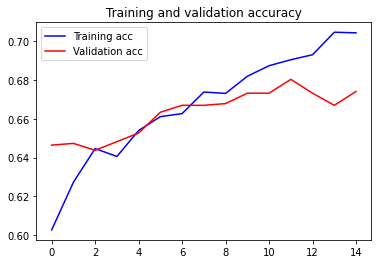

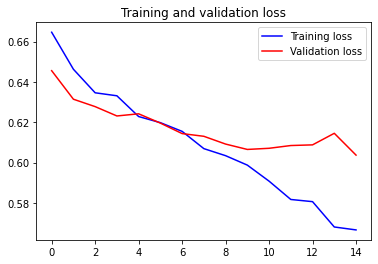

2022-07-18 17:26:50.165706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1008000000 exceeds 10% of free system memory.
2022-07-18 17:26:50.320938: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1008000000 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step


In [18]:
y_test_1d_brute, y_pred_1d_brute = lstm_model(x_train_brute, x_test_brute,
                                              y_test_brute, y_train_brute,
                                              embedding_layer_brute,
                                              tokenizer_brute)

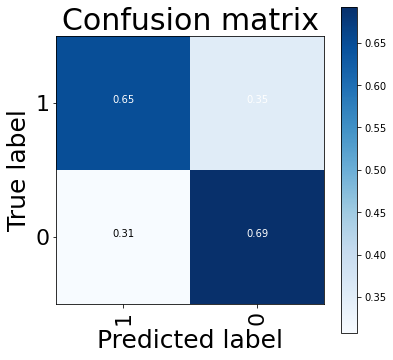

In [19]:
cnf_matrix = confusion_matrix(y_test_1d_brute, y_pred_1d_brute)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [20]:
df_classement_model = df_classement("W2V+LSTM+brute", y_test_1d_brute,
                                    y_pred_1d_brute)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643


### Avec tweet traite

Nous faisons exactement la même chose mais cette fois ci avec les **"tweet_traite"**.

In [21]:
x_train_traite, x_test_traite, y_test_traite, y_train_traite, embedding_layer_traite, tokenizer_traite = word2vec(
    'tweet_traite')

Vocab size 1257
Total words 13815
y_test (2800, 1)
x_train (11200, 300)
y_train (11200, 1)
x_test (2800, 300)
(13815, 300)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          4144500   
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,305,001
Trainable params: 160,501
Non-trainable params: 4,144,500
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 59s 559ms/step - loss: 0.6324 - accuracy: 0.6395 - val_loss: 0.6086 - val_accuracy: 0.6830
Epoch 2/15
101/101 [=====

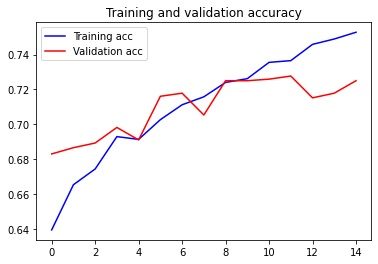

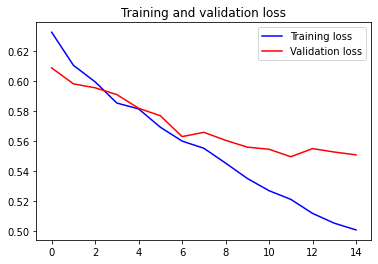

2022-07-18 17:40:44.410929: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1008000000 exceeds 10% of free system memory.
2022-07-18 17:40:44.752522: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1008000000 exceeds 10% of free system memory.


1/1 [==============================] - 4s 4s/step


In [22]:
y_test_1d_traite, y_pred_1d_traite = lstm_model(x_train_traite, x_test_traite,
                                                y_test_traite, y_train_traite,
                                                embedding_layer_traite,
                                                tokenizer_traite)

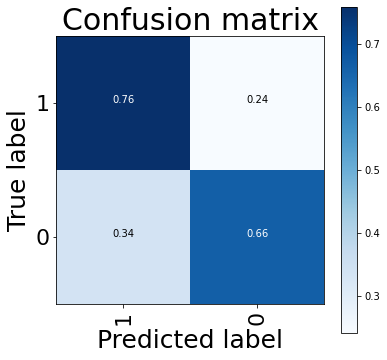

CPU times: user 283 ms, sys: 48.7 ms, total: 332 ms
Wall time: 302 ms


In [23]:
%%time
cnf_matrix = confusion_matrix(y_test_1d_traite, y_pred_1d_traite)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [24]:
df_classement_model = df_classement("W2V+LSTM+traite", y_test_1d_traite,
                                    y_pred_1d_traite)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143


### Avec tweet stemm

La même chose avec les **"tweet_stemm"**.

In [25]:
x_train_stemm, x_test_stemm, y_test_stemm, y_train_stemm, embedding_layer_stemm, tokenizer_stemm = word2vec(
    'tweet_stemm')

Vocab size 1222
Total words 11113
y_test (2800, 1)
x_train (11200, 300)
y_train (11200, 1)
x_test (2800, 300)
(11113, 300)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          3333900   
                                                                 
 dropout_2 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,494,401
Trainable params: 160,501
Non-trainable params: 3,333,900
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 63s 594ms/step - loss: 0.6258 - accuracy: 0.6536 - val_loss: 0.6137 - val_accuracy: 0.6625
Epoch 2/15
101/101 [=====

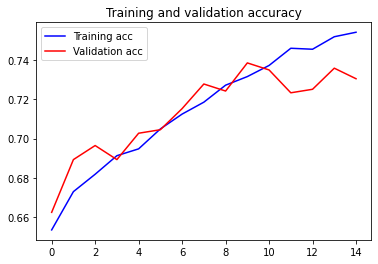

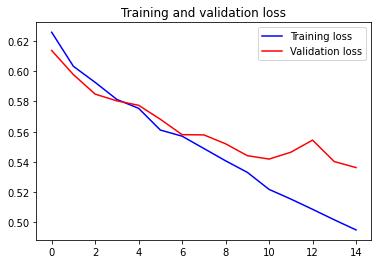

2022-07-18 17:55:03.414262: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1008000000 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step


In [26]:
y_test_1d_stemm, y_pred_1d_stemm = lstm_model(x_train_stemm, x_test_stemm,
                                              y_test_stemm, y_train_stemm,
                                              embedding_layer_stemm,
                                              tokenizer_stemm)

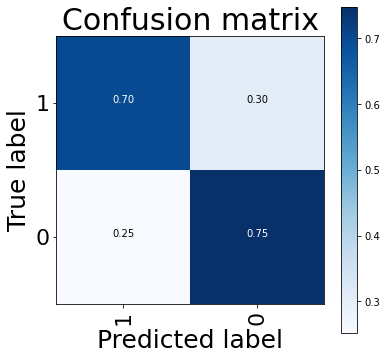

CPU times: user 220 ms, sys: 46 ms, total: 266 ms
Wall time: 212 ms


In [27]:
%%time
cnf_matrix = confusion_matrix(y_test_1d_stemm, y_pred_1d_stemm)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [28]:
df_classement_model = df_classement("W2V+LSTM+stemm", y_test_1d_stemm,
                                    y_pred_1d_stemm)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143
2,W2V+LSTM+stemm,0.727273,0.722500


### Avec tweet lemm

In [29]:
x_train_lemm, x_test_lemm, y_test_lemm, y_train_lemm, embedding_layer_lemm, tokenizer_lemm = word2vec(
    'tweet_lemm')

Vocab size 1149
Total words 11854
y_test (2800, 1)
x_train (11200, 300)
y_train (11200, 1)
x_test (2800, 300)
(11854, 300)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          3556200   
                                                                 
 dropout_3 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,716,701
Trainable params: 160,501
Non-trainable params: 3,556,200
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 60s 575ms/step - loss: 0.6270 - accuracy: 0.6479 - val_loss: 0.6107 - val_accuracy: 0.6696
Epoch 2/15
101/101 [=====

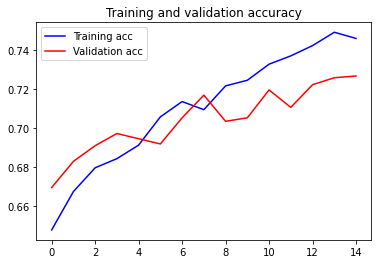

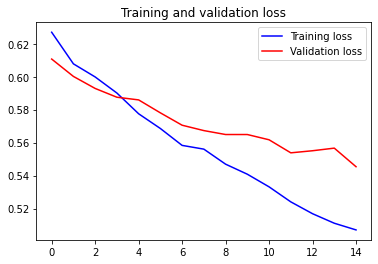

1/1 [==============================] - 4s 4s/step


In [30]:
y_test_1d_lemm, y_pred_1d_lemm = lstm_model(x_train_lemm, x_test_lemm,
                                            y_test_lemm, y_train_lemm,
                                            embedding_layer_lemm,
                                            tokenizer_lemm)

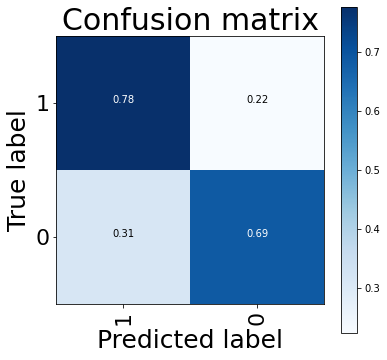

CPU times: user 158 ms, sys: 126 ms, total: 284 ms
Wall time: 286 ms


In [31]:
%%time
cnf_matrix = confusion_matrix(y_test_1d_lemm, y_pred_1d_lemm)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [32]:
df_classement_model = df_classement("W2V+LSTM+lemm", y_test_1d_lemm,
                                    y_pred_1d_lemm)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143
2,W2V+LSTM+stemm,0.727273,0.722500
3,W2V+LSTM+lemm,0.716440,0.731429


Nous avons maintenant terminé la partie avec pour word embedding **Word2Vec** et pour modèle **LSTM**.

Voici les scores obtenues.

<AxesSubplot:ylabel='model'>

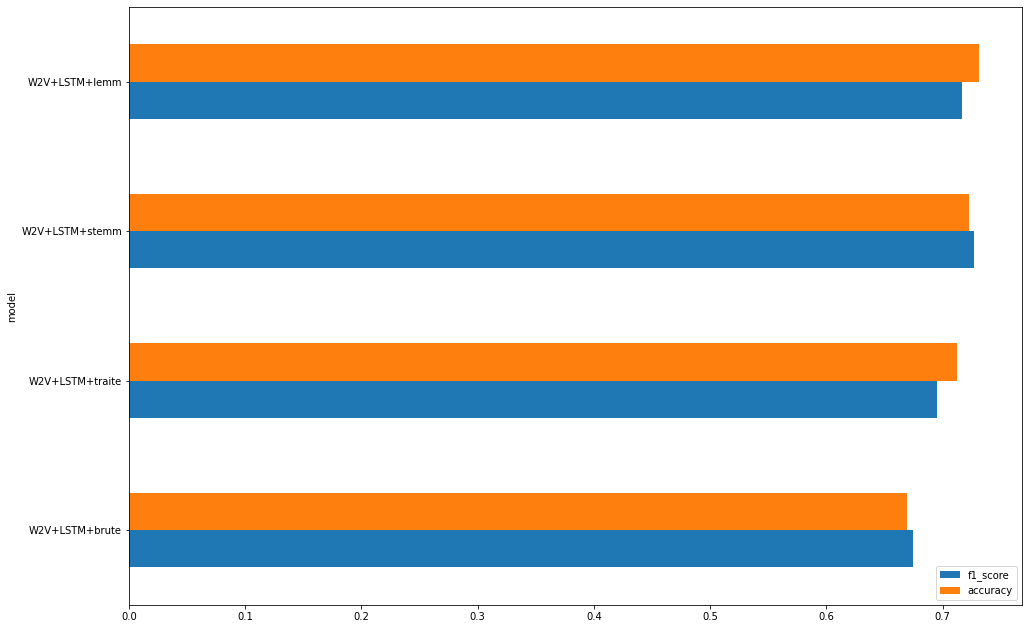

In [33]:
df_classement_model.plot.barh(x='model', figsize=(16, 11))

# Modèle | Glov

In [34]:
df_train, df_test = train_test_split(df_glov,
                                     test_size=1 - TRAIN_SIZE,
                                     random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 11200
TEST size: 2800


## Modèle avancé

### Avec tweet brute

In [35]:
x_train_brute, x_test_brute, y_test_brute, y_train_brute, embedding_layer_brute, tokenizer_brute = glov(
    "tweet")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 300)           6195300   
                                                                 
 dropout_4 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,355,801
Trainable params: 160,501
Non-trainable params: 6,195,300
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 9s 67ms/step - loss: 0.6325 - accuracy: 0.6379 - val_loss: 0.5668 - val_accuracy: 0.6964
Epoch 2/15
101/101 [=======

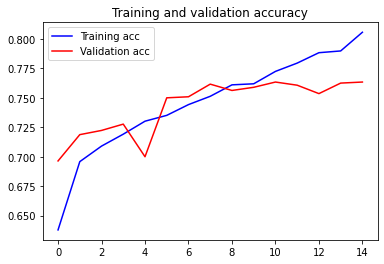

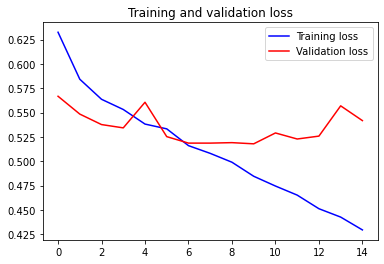

1/1 [==============================] - 0s 474ms/step


In [36]:
y_test_1d_brute, y_pred_1d_brute = lstm_model(x_train_brute, x_test_brute,
                                              y_test_brute, y_train_brute,
                                              embedding_layer_brute,
                                              tokenizer_brute)

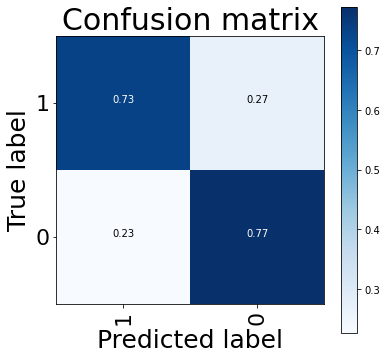

In [37]:
cnf_matrix = confusion_matrix(y_test_1d_brute, y_pred_1d_brute)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [38]:
df_classement_model = df_classement("GLOVE+LSTM+brute", y_test_1d_brute,
                                    y_pred_1d_brute)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143
2,W2V+LSTM+stemm,0.727273,0.722500
3,W2V+LSTM+lemm,0.716440,0.731429
4,GLOVE+LSTM+brute,0.756089,0.753214


### Avec tweet traite

In [39]:
x_train_traite, x_test_traite, y_test_traite, y_train_traite, embedding_layer_traite, tokenizer_traite = glov(
    'tweet_traite')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 300)           4144500   
                                                                 
 dropout_5 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               160400    
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,305,001
Trainable params: 160,501
Non-trainable params: 4,144,500
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 9s 65ms/step - loss: 0.6172 - accuracy: 0.6557 - val_loss: 0.5483 - val_accuracy: 0.7063
Epoch 2/15
101/101 [=======

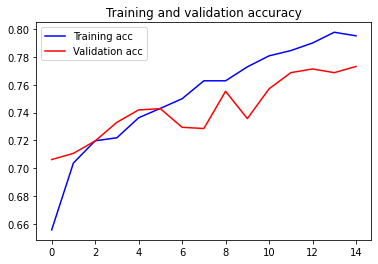

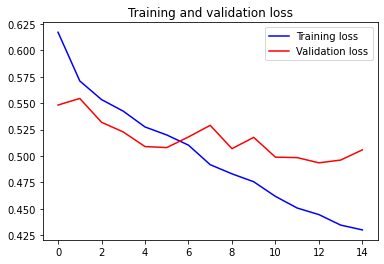

1/1 [==============================] - 0s 435ms/step


In [40]:
y_test_1d_traite, y_pred_1d_traite = lstm_model(x_train_traite, x_test_traite,
                                                y_test_traite, y_train_traite,
                                                embedding_layer_traite,
                                                tokenizer_traite)

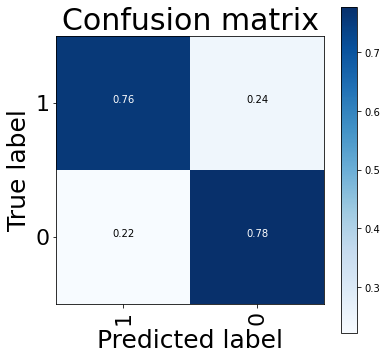

In [41]:
cnf_matrix = confusion_matrix(y_test_1d_traite, y_pred_1d_traite)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [42]:
df_classement_model = df_classement("GLOVE+LSTM+traite", y_test_1d_traite,
                                    y_pred_1d_traite)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143
2,W2V+LSTM+stemm,0.727273,0.722500
3,W2V+LSTM+lemm,0.716440,0.731429
4,GLOVE+LSTM+brute,0.756089,0.753214
5,GLOVE+LSTM+traite,0.767367,0.766786


### Avec tweet stemm

In [43]:
x_train_stemm, x_test_stemm, y_test_stemm, y_train_stemm, embedding_layer_stemm, tokenizer_stemm = glov(
    'tweet_stemm')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 300)           3333900   
                                                                 
 dropout_6 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               160400    
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,494,401
Trainable params: 160,501
Non-trainable params: 3,333,900
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 9s 67ms/step - loss: 0.6308 - accuracy: 0.6394 - val_loss: 0.5680 - val_accuracy: 0.6955
Epoch 2/15
101/101 [=======

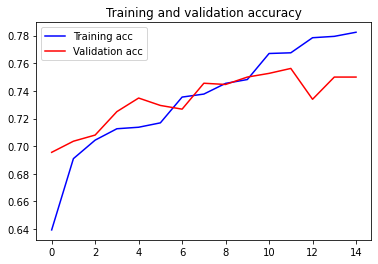

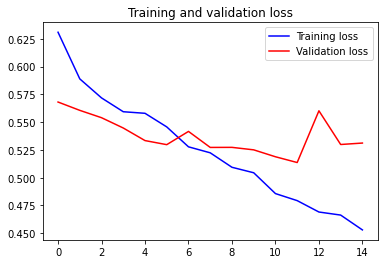

1/1 [==============================] - 1s 656ms/step


In [44]:
y_test_1d_stemm, y_pred_1d_stemm = lstm_model(x_train_stemm, x_test_stemm,
                                              y_test_stemm, y_train_stemm,
                                              embedding_layer_stemm,
                                              tokenizer_stemm)

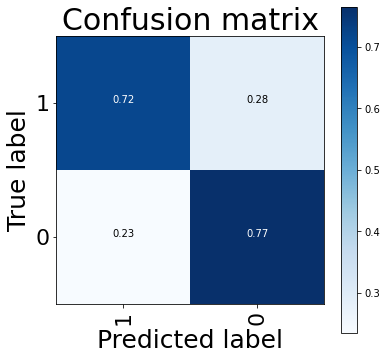

In [45]:
cnf_matrix = confusion_matrix(y_test_1d_stemm, y_pred_1d_stemm)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [46]:
df_classement_model = df_classement("GLOVE+LSTM+stemm", y_test_1d_stemm,
                                    y_pred_1d_stemm)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143
2,W2V+LSTM+stemm,0.727273,0.722500
3,W2V+LSTM+lemm,0.716440,0.731429
4,GLOVE+LSTM+brute,0.756089,0.753214
5,GLOVE+LSTM+traite,0.767367,0.766786
6,GLOVE+LSTM+stemm,0.745167,0.741071


### Avec tweet lemm

In [47]:
x_train_lemm, x_test_lemm, y_test_lemm, y_train_lemm, embedding_layer_lemm, tokenizer_lemm = glov(
    'tweet_lemm')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 300)           3556200   
                                                                 
 dropout_7 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               160400    
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,716,701
Trainable params: 160,501
Non-trainable params: 3,556,200
_________________________________________________________________
Epoch 1/15
101/101 [==============================] - 10s 79ms/step - loss: 0.6137 - accuracy: 0.6651 - val_loss: 0.5666 - val_accuracy: 0.6866
Epoch 2/15
101/101 [======

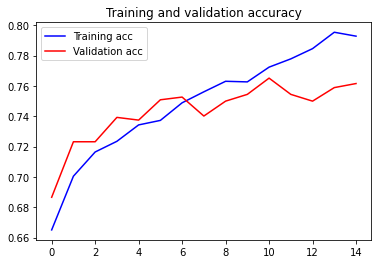

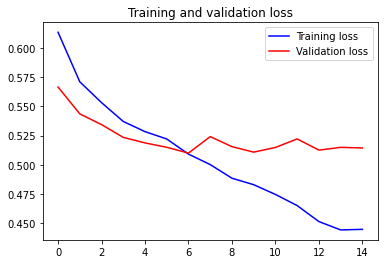

1/1 [==============================] - 0s 411ms/step


In [48]:
y_test_1d_lemm, y_pred_1d_lemm = lstm_model(x_train_lemm, x_test_lemm,
                                            y_test_lemm, y_train_lemm,
                                            embedding_layer_lemm,
                                            tokenizer_lemm)

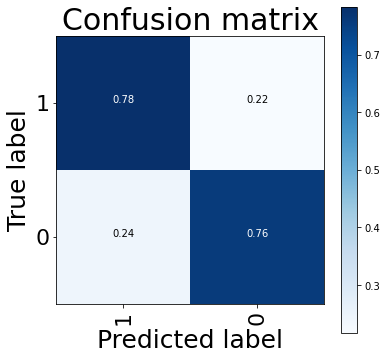

In [49]:
cnf_matrix = confusion_matrix(y_test_1d_lemm, y_pred_1d_lemm)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.sentiment.unique(),
                      title="Confusion matrix")
plt.show()

In [50]:
df_classement_model = df_classement("GLOVE+LSTM+lemm", y_test_1d_lemm,
                                    y_pred_1d_lemm)
df_classement_model

/tmp/ipykernel_10606/718858219.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_classement_model.append(


,model,f1_score,accuracy
0,W2V+LSTM+brute,0.674639,0.669643
1,W2V+LSTM+traite,0.695389,0.712143
2,W2V+LSTM+stemm,0.727273,0.722500
3,W2V+LSTM+lemm,0.716440,0.731429
4,GLOVE+LSTM+brute,0.756089,0.753214
5,GLOVE+LSTM+traite,0.767367,0.766786
6,GLOVE+LSTM+stemm,0.745167,0.741071
7,GLOVE+LSTM+lemm,0.765414,0.770357


<AxesSubplot:ylabel='model'>

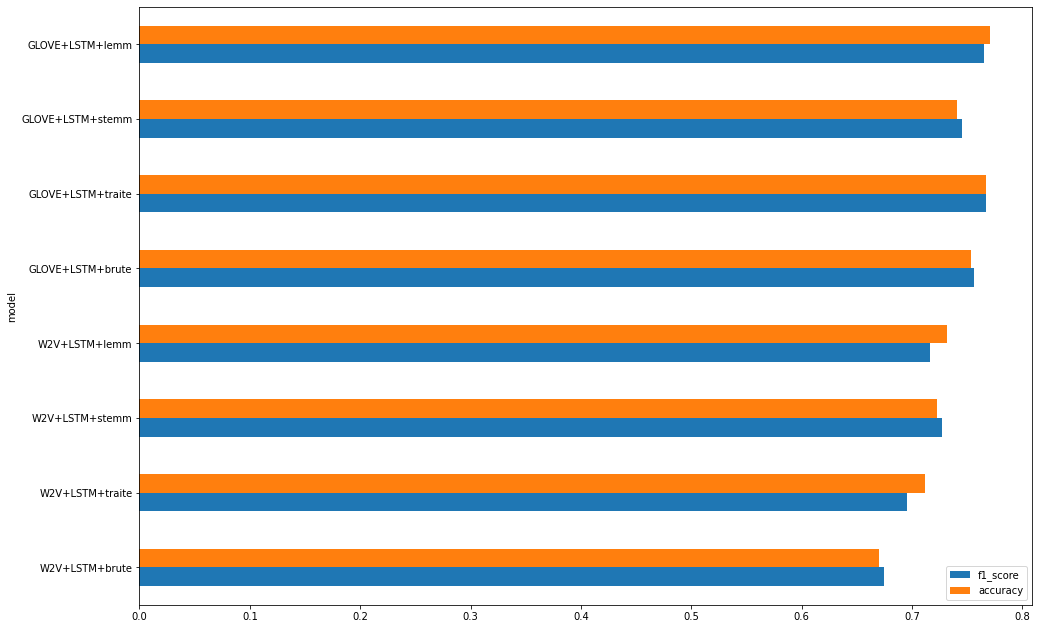

In [51]:
df_classement_model.plot.barh(x='model', figsize=(16, 11))

# BERT

# BERT avec modèle avancé

# Comparatif

# Conclusion

In [52]:
b = datetime.now()
print(b-a)

1:05:27.865934
